## II. ANALYZING AIR QUALITY IN BANGKOK

In [191]:
import pandas as pd
import requests
import folium
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Loading the data

In [ ]:
# Package the request, send the request and catch the response: r
r = requests.get('https://api.openaq.org/v1/measurements?limit=10000&city=Bangkok')
json_data = r.json()['results']

In [57]:
rows_list = []

for m in json_data:
    row = {'city': m['city'],
           'lon': m['coordinates']['longitude'],
           'lat': m['coordinates']['latitude'],
           'time': m['date']['local'],
           'loc': m['location'],
           'param': m['parameter'],
           'unit': m['unit'],
           'value': m['value']
          }
    rows_list.append(row)

data = pd.DataFrame(rows_list) 
data = data[['city','lon','lat','time','loc','param','unit','value']]

In [58]:
data.shape

(10000, 8)

In [59]:
data.head()

,city,lon,lat,time,loc,param,unit,value
0,Bangkok,100.605741,13.666116,2017-11-17T19:00:00+07:00,"Bangna, Bangna",co,ppm,0.940
1,Bangkok,100.505812,13.668461,2017-11-17T19:00:00+07:00,"Samae Dam, Bang Khun Thian",o3,ppm,0.001
2,Bangkok,100.605741,13.666116,2017-11-17T19:00:00+07:00,"Bangna, Bangna",no2,ppm,0.048
3,Bangkok,100.505812,13.668461,2017-11-17T19:00:00+07:00,"Samae Dam, Bang Khun Thian",pm10,µg/m³,65.000
4,Bangkok,100.596078,13.792635,2017-11-17T19:00:00+07:00,"Lat Phrao Rd., Wang Thonglang",no2,ppm,0.038


## 2. Getting acquainted with the data

### Counts per values

In [114]:
def count_by(df, col_name):
    print('-'*30)
    print('# of measurements by: "' + col_name + '"\n\n', data[col_name].value_counts())

In [115]:
for c in ['city', 'loc', 'param', 'unit']:
    count_by(data, c)

------------------------------
# of measurements by: "city"

 Bangkok    10000
Name: city, dtype: int64
------------------------------
# of measurements by: "loc"

 Intarapitak Rd., Thon Buri       2157
Bangna, Bangna                   2020
Khlong Chan, Bang kapi           1526
Lat Phrao Rd., Wang Thonglang    1482
Samae Dam, Bang Khun Thian       1309
Rama IV Rd., Pathum Wan          1306
Chong Nonsi, Yannawa              141
Pubpla, Wang Thonglang             48
Samsen Nai, Khet Phaya Thai        11
Name: loc, dtype: int64
------------------------------
# of measurements by: "param"

 no2     2710
pm10    2662
co      2014
o3      1722
so2      892
Name: param, dtype: int64
------------------------------
# of measurements by: "unit"

 ppm      7338
µg/m³    2662
Name: unit, dtype: int64


### Mapping measurement locations

In [120]:
# https://folium.readthedocs.io/en/latest/quickstart.html#getting-started
# https://deparkes.co.uk/2016/06/10/folium-map-tiles/
# http://nbviewer.jupyter.org/github/python-visualization/folium/tree/master/examples/

In [259]:
map_loc = folium.Map(location=[13.7563, 100.5018], tiles='cartodbpositron', zoom_start=11)

In [260]:
# Locations of interest
data[['loc', 'lon', 'lat']].drop_duplicates()

,loc,lon,lat
0,"Bangna, Bangna",100.605741,13.666116
1,"Samae Dam, Bang Khun Thian",100.505812,13.668461
4,"Lat Phrao Rd., Wang Thonglang",100.596078,13.792635
7,"Intarapitak Rd., Thon Buri",100.486604,13.727559
11,"Chong Nonsi, Yannawa",100.547345,13.708041
20,"Khlong Chan, Bang kapi",100.636548,13.781520
206,"Pubpla, Wang Thonglang",100.614562,13.769630
1360,"Rama IV Rd., Pathum Wan",100.536494,13.729830
4895,"Samsen Nai, Khet Phaya Thai",100.537798,13.780444


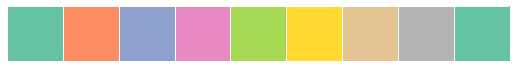

In [261]:
nb_loc = len(data[['loc', 'lon', 'lat']].drop_duplicates())
color_palette = sns.color_palette("Set2", nb_loc)
sns.palplot(color_palette)

In [263]:
col_idx = 0
for row in data[['loc', 'lon', 'lat']].drop_duplicates().itertuples():
    location, lon, lat = row[1:4]
    folium.CircleMarker([lat, lon],
                        radius=10,
                        popup='<i>' + location + '</i>',
                        color=color_palette.as_hex()[col_idx],
                        fill=True,
                        fill_color=color_palette.as_hex()[col_idx],
                        fill_opacity=0.8,
                        line_opacity=0.8
                       ).add_to(map_loc)
    col_idx += 1

In [265]:
map_loc